In [1]:
#https://www.tensorflow.org/api_docs/python/tf
#https://keras.io/guides/
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
original = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data_2/bearbeitet/train/original/*.*')
bearbeitet = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data_2/bearbeitet/train/processed/*.*')

data = []
labels = []
name = []

for i in original:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    #name.append(i)
    labels.append(0)
for i in bearbeitet:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    #name.append(i)
    labels.append(1)
#print(name[1])    
data = np.array(data)
labels = np.array(labels)
#name = np.array(name)
#print(name[1])

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=8)
x_train = x_train/255.0

In [3]:
print(x_name)

NameError: name 'x_name' is not defined

In [3]:
num_classes = 2 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 2000
batch_size = 64
display_step = 100

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
#https://github.com/pkorus/neural-imaging
class ConstrainedConv2D(tf.keras.layers.Layer):
    """
    Implementation of a trainable constrained residual filter (based on [1] and extended to RGB inputs). 
    The layer learns a 2D convolution filter (5, 5, 3, 3) where:
    - a central pixel in each channel [2, 2, i, i] is set to a fixed negative value
    - each output channel is normalized to sum to 0 [:, :, :, i]
    
    For example, an intra-channel filter [:, :, i, i] may look like:
    [  -0.73    0.41   -1.24   -1.26    0.69]
    [  -0.29    7.91   17.53    8.6     0.29]
    [  -0.62   16.7  -100.0    16.1     0.22]
    [   0.54    9.3    16.05    8.19    0.98]
    [  -0.57   -0.7    -0.4     1.22   -0.13]
    The layer is pre-initialized with a simple residual filter with no intra-channel interactions.
    # References
    [1] Bayar & Stamm, Constrained convolutional neural networks: A new approach towards general purpose image 
        manipulation detection. IEEE Transactions on Information Forensics and Security, 13 (11), 2018
    """

    def __init__(self, filter_strength=100, trainable=True):
        super().__init__()
        self.filter_strength = filter_strength

        f = np.array([[0, 0, 0, 0, 0], [0, -1, -2, -1, 0], [0, -2, 12, -2, 0], [0, -1, -2, -1, 0], [0, 0, 0, 0, 0]])
        self.kernel = self.add_weight("kernel", shape=(5, 5, 3, 3),
                                      initializer=tf.constant_initializer(repeat_2dfilter(f, 3)),
                                      trainable=trainable)
        

    def call(self, input):
        # Mask for normalizing the residual filter
        tf_ind = tf.constant(center_mask_2dfilter(5, 3), dtype=tf.float32)

        # Normalize the residual filter
        nf = self.kernel * (1 - tf_ind)
        df = tf.tile(tf.reshape(tf.reduce_sum(nf, axis=(0,1,2)), [1, 1, 1, 3]), [5, 5, 3, 1])
        nf = self.filter_strength * nf / df
        #nf = nf/df
        nf = nf - self.filter_strength * tf_ind
        #nf = nf-tf_ind

        # Convolution with the residual filter
        xp = tf.pad(input, [[0, 0], [2, 2], [2, 2], [0, 0]], 'SYMMETRIC')
        
        
        return tf.nn.conv2d(xp, nf, [1, 1, 1, 1], 'VALID')

In [6]:
#https://github.com/pkorus/neural-imaging
def repeat_2dfilter(f, channels=3, pad=0):
    """
    Repeat a 2D filter along channel dimensions (both input/output). Useful for kernel initialization in conv. layers.
    :param f: 2d filter
    :param channels: number of input/output channels
    :param pad: optional padding (along the spatial dimension)
    :return: valid conv 2d kernel (kernel, kernel, channels, channels)
    """
    rf = np.zeros((f.shape[0] + 2 * pad, f.shape[1] + 2 * pad, channels, channels))

    for r in range(channels):
        rf[:, :, r, r] = np.pad(f, [pad, pad], 'constant')

    return rf

In [7]:
#https://github.com/pkorus/neural-imaging

def center_mask_2dfilter(f_size, channels):
    indicator = np.zeros((f_size, f_size, channels, channels))

    for r in range(channels):
        indicator[f_size // 2, f_size // 2, r, r] = 1

    return indicator

In [8]:
# Create TF Model.
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with 32 filters and a kernel size of 5.
        #self.testconv = MlpLayer([32,256,256,3],["relu", "softmax"])
        self.x = tf.keras.Input(dtype=tf.float32, shape=(batch_size, batch_size, 3))
        self.testconv = ConstrainedConv2D()
        self.conv1 = layers.Conv2D(96, kernel_size=7, strides=[2,2], padding='same')
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.activ1 = tf.keras.layers.Activation('tanh')
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool1 = layers.MaxPool2D(3, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv2 = layers.Conv2D(64, kernel_size=5, strides=[1,1], padding='same')
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.activ2 = tf.keras.layers.Activation('tanh')
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool2 = layers.MaxPool2D(3, strides=2)
        
        self.conv3 = layers.Conv2D(64,kernel_size=5, strides=[1,1], padding='same')
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.activ3 = tf.keras.layers.Activation('tanh')

        self.maxpool3 = layers.MaxPool2D(3, strides=2)
        # Flatten the data to a 1-D vector for the fully connected layer.
        self.conv4 = layers.Conv2D(128,kernel_size=1, strides=[1,1])
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        self.activ4 = tf.keras.layers.Activation('tanh')

        self.avgpool1 = layers.AveragePooling2D(3, strides=2)
        
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(200, activation=tf.nn.tanh)
        # Apply Dropout (if is_training is False, dropout is not applied).
        #self.dropout = layers.Dropout(rate=0.5)
        self.fc2 = layers.Dense(200, activation=tf.nn.tanh)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes, activation ='softmax')

    # Set forward pass.
    def call(self, x, is_training=False):
        print("first")
        print(x.shape.dims)
        x = tf.reshape(x, [-1, 256, 256, 3])
        print("sec")
        print(x.shape.dims)
        x = self.testconv(x)
        print("third")
        print(x.shape.dims)
        x = self.conv1(x)
        print("forth")
        print(x.shape.dims)
        x = self.batchnorm1(x)
        x = self.activ1(x)
        x = self.maxpool1(x)
        #print("test")
        #print(x.shape.dims)
        x = self.conv2(x)
        #print("five")
        #print(x.shape.dims)
        x = self.batchnorm2(x)
        x = self.activ2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        #print("six")
        #print(x.shape.dims)
        x = self.batchnorm3(x)
        x = self.activ3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        #print("seven")
        #print(x.shape.dims)
        x = self.batchnorm4(x)
        x = self.activ4(x)
        x = self.avgpool1(x)
        x = self.flatten(x)
       # print("eight")
        #print(x.shape.dims)
        x = self.fc1(x)
        #print("nine")
        #print(x.shape.dims)
        x = self.fc2(x)
        #print("ten")
        #print(x.shape.dims)
        #x = self.dropout(x, training=is_training)
        x = self.out(x)
        #print("elvene")
        #print(x.shape.dims)
        #if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            #x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [9]:
#https://stackoverflow.com/questions/51440135/tensorflow-stop-training-when-losses-reach-a-defined-value
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <= 0.00005):
            print("\n\n\nReached 0.05 loss value so cancelling training!\n\n\n")
            self.model.stop_training = True
            
callback = haltCallback()

In [10]:
x_test = x_test/255.0

In [11]:
sgd = tf.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.000001)
#sgd = tf.optimizers.SGD(lr=0.001, momentum=0.95)
conv_net.compile(optimizer=sgd,loss ='sparse_categorical_crossentropy', metrics=['accuracy'])
#conv_net.build()

In [ ]:
conv_net.fit(x_train, y_train, batch_size = 64, epochs = 600, callbacks =[callback])

Epoch 1/600
first
[Dimension(64), Dimension(256), Dimension(256), Dimension(3)]
sec
[Dimension(64), Dimension(256), Dimension(256), Dimension(3)]
third
[Dimension(64), Dimension(256), Dimension(256), Dimension(3)]
forth
[Dimension(64), Dimension(128), Dimension(128), Dimension(96)]
first
[Dimension(64), Dimension(256), Dimension(256), Dimension(3)]
sec
[Dimension(64), Dimension(256), Dimension(256), Dimension(3)]
third
[Dimension(64), Dimension(256), Dimension(256), Dimension(3)]
forth
[Dimension(64), Dimension(128), Dimension(128), Dimension(96)]
25/25 [==============================] - 8s 106ms/step - loss: 0.7830 - accuracy: 0.5011
Epoch 2/600
25/25 [==============================] - 3s 106ms/step - loss: 0.6948 - accuracy: 0.5482
Epoch 3/600
25/25 [==============================] - 3s 106ms/step - loss: 0.6666 - accuracy: 0.5932
Epoch 4/600
25/25 [==============================] - 3s 106ms/step - loss: 0.6662 - accuracy: 0.5938
Epoch 5/600
25/25 [==============================] - 3

25/25 [==============================] - 3s 105ms/step - loss: 0.0752 - accuracy: 0.9709
Epoch 74/600
25/25 [==============================] - 3s 104ms/step - loss: 0.0731 - accuracy: 0.9693
Epoch 75/600
25/25 [==============================] - 3s 105ms/step - loss: 0.0713 - accuracy: 0.9713
Epoch 76/600
25/25 [==============================] - 3s 105ms/step - loss: 0.0863 - accuracy: 0.9689
Epoch 77/600
25/25 [==============================] - 3s 104ms/step - loss: 0.1059 - accuracy: 0.9580
Epoch 78/600
25/25 [==============================] - 3s 105ms/step - loss: 0.0846 - accuracy: 0.9637
Epoch 79/600
25/25 [==============================] - 3s 105ms/step - loss: 0.0562 - accuracy: 0.9846
Epoch 80/600
25/25 [==============================] - 3s 105ms/step - loss: 0.0496 - accuracy: 0.9809
Epoch 81/600
25/25 [==============================] - 3s 104ms/step - loss: 0.0938 - accuracy: 0.9623
Epoch 82/600
25/25 [==============================] - 3s 105ms/step - loss: 0.0798 - accuracy: 

25/25 [==============================] - 3s 104ms/step - loss: 2.4891e-04 - accuracy: 1.0000
Epoch 152/600
25/25 [==============================] - 3s 104ms/step - loss: 1.7378e-04 - accuracy: 1.0000
Epoch 153/600
25/25 [==============================] - 3s 105ms/step - loss: 2.3182e-04 - accuracy: 1.0000
Epoch 154/600
25/25 [==============================] - 3s 104ms/step - loss: 2.0150e-04 - accuracy: 1.0000
Epoch 155/600
25/25 [==============================] - 3s 107ms/step - loss: 1.9238e-04 - accuracy: 1.0000
Epoch 156/600
25/25 [==============================] - 3s 108ms/step - loss: 2.5317e-04 - accuracy: 1.0000
Epoch 157/600
25/25 [==============================] - 3s 107ms/step - loss: 2.0464e-04 - accuracy: 1.0000
Epoch 158/600
25/25 [==============================] - 3s 106ms/step - loss: 1.5437e-04 - accuracy: 1.0000
Epoch 159/600
25/25 [==============================] - 3s 106ms/step - loss: 2.6262e-04 - accuracy: 1.0000
Epoch 160/600
25/25 [==============================

25/25 [==============================] - 3s 105ms/step - loss: 1.1836e-04 - accuracy: 1.0000
Epoch 228/600
25/25 [==============================] - 3s 106ms/step - loss: 8.3396e-05 - accuracy: 1.0000
Epoch 229/600
25/25 [==============================] - 3s 106ms/step - loss: 9.8185e-05 - accuracy: 1.0000
Epoch 230/600
25/25 [==============================] - 3s 105ms/step - loss: 8.5893e-05 - accuracy: 1.0000
Epoch 231/600
25/25 [==============================] - 3s 106ms/step - loss: 5.4556e-05 - accuracy: 1.0000
Epoch 232/600
25/25 [==============================] - 3s 105ms/step - loss: 9.2084e-05 - accuracy: 1.0000
Epoch 233/600
25/25 [==============================] - 3s 105ms/step - loss: 9.5478e-05 - accuracy: 1.0000
Epoch 234/600
25/25 [==============================] - 3s 105ms/step - loss: 6.3555e-05 - accuracy: 1.0000
Epoch 235/600
25/25 [==============================] - 3s 105ms/step - loss: 5.4785e-05 - accuracy: 1.0000
Epoch 236/600
25/25 [==============================

In [ ]:
print(x_test.shape)

In [ ]:
loss, acc = conv_net.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


In [14]:
y_pred = np.argmax(conv_net.predict(x_test), axis=1)

In [ ]:
import pandas as pd
pd.DataFrame(y_pred).to_csv("pred.csv", header=None, index=None)
pd.DataFrame(y_test).to_csv("test.csv", header=None, index=None)

In [ ]:
conv_net.summary()

In [ ]:
conv_net.save('my_model_2_classes_var')

In [ ]:
print(y_test)

In [ ]:
print(y_pred)


In [40]:
l = len(y_test)
test = 0
acc = sum([y_pred[i]==y_test[i] for i in range(l)])/l
for i in range (l):
    if y_pred[i]==y_test[i]:
        test = test+1
print(test)
print(acc)
print(l)

324
0.81
400


(-0.5, 255.5, 255.5, -0.5)

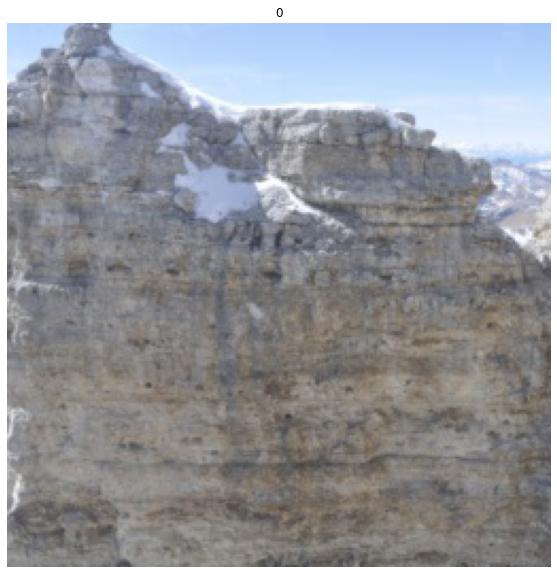

In [41]:
plt.figure(figsize=(10, 10))
#ax = plt.subplot(3, 3, i + 1)
plt.imshow(x_test[7])
plt.title(y_test[7])
plt.axis("off")


In [21]:
original = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data_2/bearbeitet/train/original/*.*')
bearbeitet = glob('C:/Users/Daniel/Documents/MCI/bach/jupyter/data_2/bearbeitet/train/processed/*.*')

data = []
labels = []
data2 = []
labels2 =[]

for i in original:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    #name.append(i)
    labels.append(0)
for i in bearbeitet:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data2.append(image)
    #name.append(i)
    labels2.append(1)
#print(name[1])    
data = np.array(data)
labels = np.array(labels)

data2 = np.array(data2)
labels2 = np.array(labels2)
#name = np.array(name)
#print(name[1])

data = data/255.0
data2 = data2/255

In [22]:
y_pred1 = np.argmax(conv_net.predict(data), axis=1)
y_pred2 = np.argmax(conv_net.predict(data2), axis=1)


In [26]:
l = len(data)
test = 0
acc = sum([y_pred1[i]==labels[i] for i in range(l)])/l
for i in range (l):
    if y_pred1[i]==labels[i]:
        test = test+1
    else:
        print(i+1)
#print(test)
print(acc)
print(l)

1
2
3
4
5
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
53
54
55
56
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
102
103
104
105
106
107
108
109
110
111
112
113
114
116
117
118
119
120
121
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
175
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
207
208
209
210
211
212
213
214
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
239
240
241
242
243
244
245
246
247
248
249
250
251
252
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
289


In [27]:
l = len(data)
test = 0
acc = sum([y_pred2[i]==labels2[i] for i in range(l)])/l
for i in range (l):
    if y_pred2[i]==labels2[i]:
        test = test+1
    else:
        print(i+1)


1
2
3
4
5
6
7
8
9
10
11
13
14
15
17
18
19
20
21
22
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
41
42
43
44
45
48
49
51
52
53
54
56
57
58
60
61
63
66
67
68
69
70
72
73
74
75
76
77
78
80
81
82
83
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
104
106
108
110
112
113
114
115
117
119
120
121
122
124
125
126
127
128
129
130
131
132
133
134
135
137
138
139
140
141
143
144
145
146
147
148
149
150
151
152
153
154
155
156
160
162
164
165
166
168
169
171
172
173
174
175
176
177
178
179
181
184
185
186
187
188
190
191
192
193
195
196
197
198
199
200
201
202
203
204
205
206
208
209
210
211
212
213
214
215
217
218
219
220
221
222
223
224
225
228
229
234
235
236
237
238
239
240
242
243
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
261
263
264
267
269
270
271
274
275
276
277
278
279
281
282
283
284
285
286
287
288
289
290
291
292
296
297
298
299
301
302
304
305
306
307
310
311
312
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
331
333
334
335
336
337
339
340
342
343
344
